In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

In [2]:
sample_freq = 1e6  # in Hz
length = 1.0  # in s
signal_strength = 0.0  # in dB
noise_strength = 0.0  # in dB

wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
sig = wm.get_soft(f_center=1.e5, dB=signal_strength)
sig += wm.get_soft(f_center=1.25e5, dB=signal_strength)
sig += wm.get_soft(f_center=1.5e5, dB=signal_strength)
sig += wm.get_soft(f_center=1.75e5, dB=signal_strength)
sig += wm.get_soft(f_center=2.e5, dB=signal_strength)
sig += wm.get_soft(f_center=-1.e5, dB=signal_strength)
sig += wm.get_soft(f_center=-2.e5, dB=signal_strength)

wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.get_signal(dB=noise_strength)

assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

both = sig + noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)

print('Signal power:    %6.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:     %6.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:             %6.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num Samples:     %9d ' % (num_samples))

# Note, that Parseval's theorem holds
from scipy import fft
print("Freqency Energy %6.2f" % (np.sum(np.abs(fft.fft(both))**2)/sample_freq))
print("Time Energy     %6.2f" % (np.sum(np.abs(both)**2)))

Signal power:      8.45 dB
Noise power:       0.00 dB
SNR:               8.45 dB
Num Samples:       1000000 
Freqency Energy 8006109.50
Time Energy     8006109.50


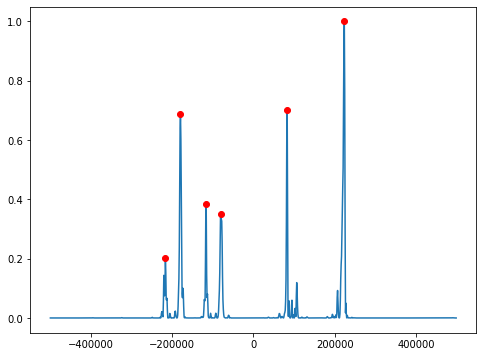

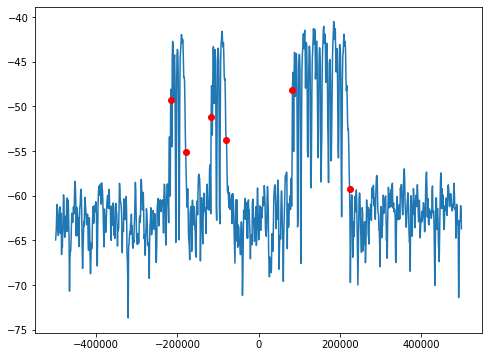

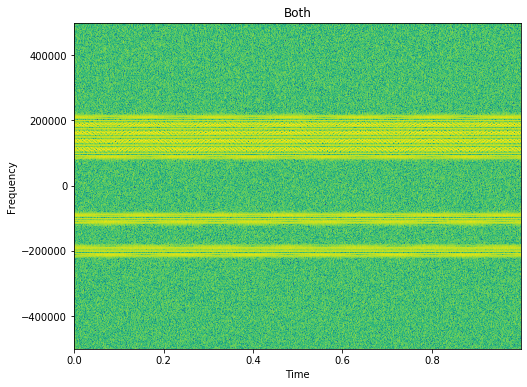

In [9]:
sft = ss.Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)

psd = ss.util_wide.psd_average(spectogram=x, start=10, stop=15)

prod, peak, peakf = ss.band_detect(psd,
                                   f,
                                   scale=5,
                                   min_height=0.2,
                                   min_freq=3e4)

plt.figure(figsize=(8, 6))
plt.plot(f, prod)
plt.plot(peakf, prod[peak], 'ro')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(f, psd)
plt.plot(peakf, psd[peak], 'ro')
plt.show()

plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Both")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

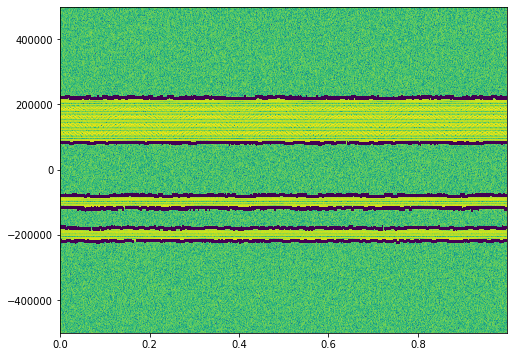

In [4]:
class VariableBandFreqEnergyDetector():
    def __init__(self, f_sample=1e6, fft_len=1024, freqs=None):
        self.f_sample = f_sample  # sample rate used with the
        self.fft_len = fft_len  # length of the fft used to compute the power spectrum
        self.freqs = freqs  # frequency band, x axis, used by the power spectrum
        self.ps_list = np.zeros(shape=(fft_len, 0))

    def ps_smooth(self, ps):
        if np.size(self.ps_list, 1) >= 10:
            self.ps_list = np.delete(self.ps_list, 0, axis=1)


#         ps_new = np.array([ps]).T
#         print(np.shape(ps_new))
#         print(np.shape(self.ps_list))
        self.ps_list = np.concatenate((self.ps_list, np.array([ps]).T), axis=1)

        #         plt.figure(figsize=(8, 6))
        #         plt.plot(self.freqs, ps)
        #         plt.show()
        #         plt.figure(figsize=(8, 6))
        #         plt.plot(self.freqs, self.ps_list[:,0])
        #         plt.show()
        return np.mean(self.ps_list, axis=1)

    def detect(self, ps):
        ps = self.ps_smooth(ps)
        prod, peak, peakf = ss.band_detect(ps,
                                           self.freqs,
                                           scale=5,
                                           min_height=0.2,
                                           min_freq=3e4)

        return ps, peak, peakf

sft = ss.Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)

ved = VariableBandFreqEnergyDetector(f_sample=1e6, fft_len=1024, freqs=f)

plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
           f,
           x,
           shading='flat',
           cmap='viridis',
           snap=True,
           vmin=np.min(x),
           vmax=np.max(x))

# plt.pcolormesh(t, f, x)

res = np.empty(shape=(len(f), len(t)))
res[:] = np.nan
for i in range(len(t)):
    ps, peak, peakf = ved.detect(x[:, i])
    #     plt.figure(figsize=(8, 6))
    #     plt.plot(f, ps)
    #     plt.plot(peakf, ps[peak], 'ro')
    #     plt.show()

    res[np.maximum(peak - 3, 0), i] = 1.
    res[np.maximum(peak - 2, 0), i] = 1.
    res[np.maximum(peak - 1, 0), i] = 1.
    res[peak, i] = 1.
    res[np.minimum(peak + 1, len(f)), i] = 1.
    res[np.minimum(peak + 2, len(f)), i] = 1.
    res[np.minimum(peak + 3, len(f)), i] = 1.


# plt.figure(figsize=(8, 6))
# plt.pcolormesh(t, f, res)
plt.pcolormesh(t,
           f,
           res,
           shading='flat',
           cmap='viridis',
           snap=True)
plt.show()